In [1]:
import sys
from importlib import reload
from pathlib import Path
from time import time

import h5py as h5
import numpy as np
from scipy.signal import savgol_filter as savgol
from scipy.stats import binned_statistic
from scipy.stats.mstats import theilslopes

import matplotlib.pyplot as plt
import matplotlib
import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

sys.path.append('/reg/neh/home4/espov/python/datastorage/')
import datastorage

import ana_fun as ana


output_notebook()

#matplotlib.rcParams.keys()
matplotlib.rcParams['figure.figsize'] = (10, 7)
matplotlib.rc('font', size=14)
COLOR = 'grey'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
length = 8
width = 1.5
matplotlib.rcParams['xtick.major.size'] = length
matplotlib.rcParams['ytick.major.size'] = length
matplotlib.rcParams['xtick.major.width'] = width
matplotlib.rcParams['ytick.major.width'] = width

Loading BokehJS ...

### Get data

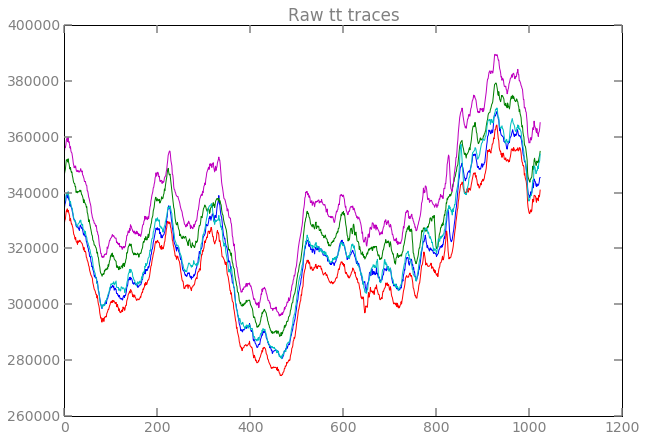

In [2]:
""" Get timing tool data """
h5path = Path('/reg/d/psdm/SXR/sxri0414/res/automated_analysis_espov/hdf5')
file = 'sxri0414run60.h5'
fh5 = h5.File(h5path / file)

file = str(h5path/file)
#file = '/reg/g/psdm/sw/hutch/sxd/analysis_methods/eigen_background_subtraction/xpptut15run420.h5'
data = datastorage.read(file)

ttdata = data.timeToolOpal

plt.plot(ttdata[:5,:].transpose())
plt.title('Raw tt traces')
plt.show()

### Get dropshots and apply svd on them

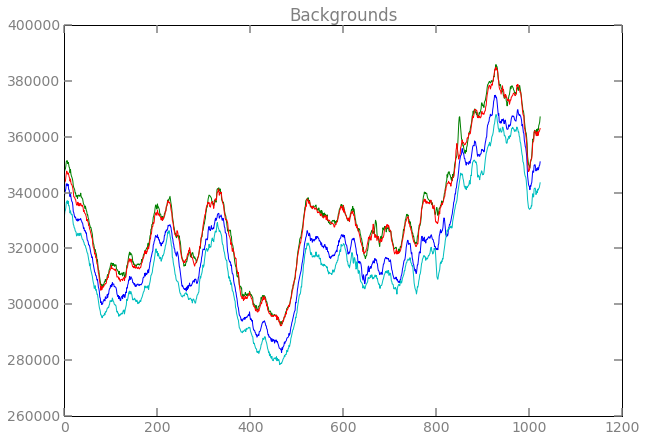

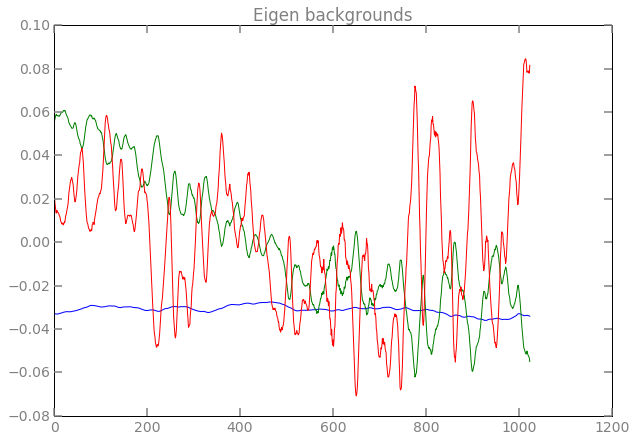

(15394, 1024)

In [3]:
u,s,v, bkgs = ana.get_svd_background(data, return_bkg=True)

plt.figure()
plt.title('Backgrounds')
plt.plot(bkgs[0])
plt.plot(bkgs[1])
plt.plot(bkgs[2])
plt.plot(bkgs[30])
plt.show()

plt.figure()
plt.title('Eigen backgrounds')
plt.plot(v[0])
plt.plot(v[1])
plt.plot(v[2])
#plt.plot(v[30])
plt.show()

bkgs.shape

### Subract svd background from timing tool traces

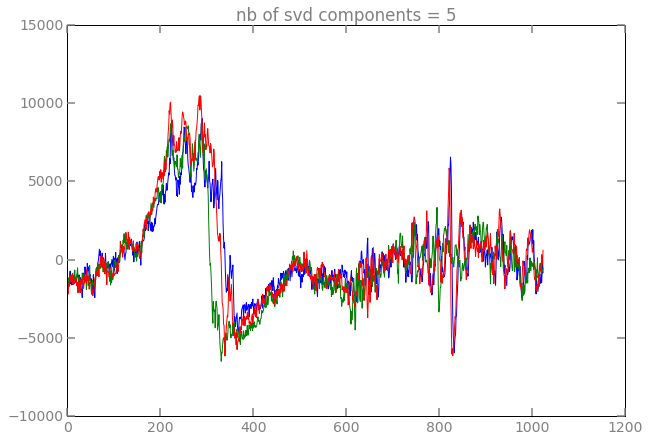

In [4]:
mask = ttdata.astype(bool)[1]
mask[200:600] = False

ttcorr = ana.subtract_svd_background(data, mask, svd_size=5)

plt.plot(ttcorr[:3].transpose())
plt.title('nb of svd components = 5')
plt.show()

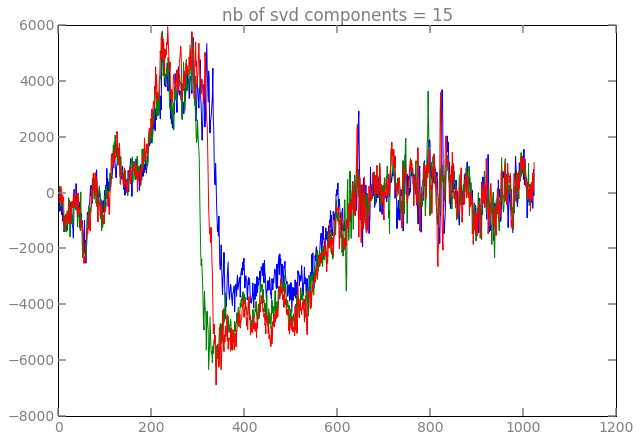

In [5]:
ttcorr = ana.subtract_svd_background(data, mask, svd_size=15)

plt.plot(ttcorr[:3].transpose())
plt.title('nb of svd components = 15')
plt.show()

In [6]:
#ttcorr = ana.subtract_svd_background(data, mask, svd_size=40)

#plt.plot(ttcorr[:3].transpose())
#plt.title('nb of svd components = 40')
#plt.show()

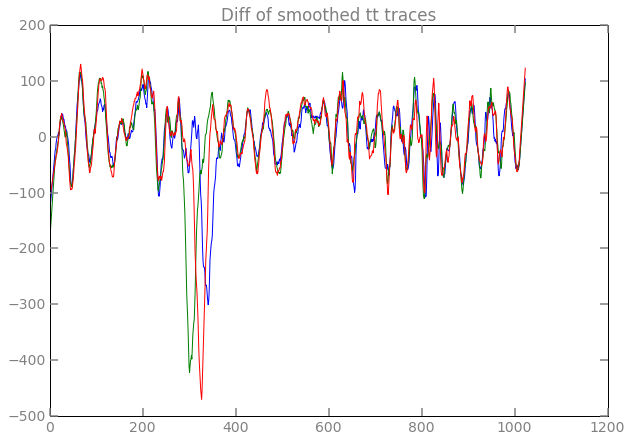

In [7]:
ttdiff = savgol(ttcorr, 25, 2, 1, axis=1)

plt.plot(ttdiff[:3].transpose())
plt.title('Diff of smoothed tt traces')
plt.show()

In [8]:
ttdiff = -ttdiff
ttdiff.shape

(261831, 1024)

### Find edge: fit peak demo

#### Nonlinear least square

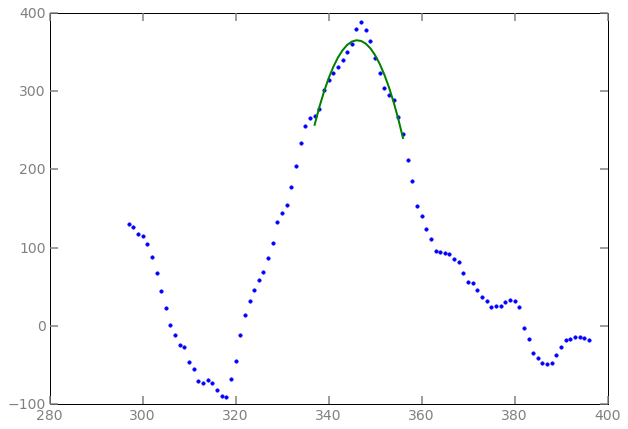

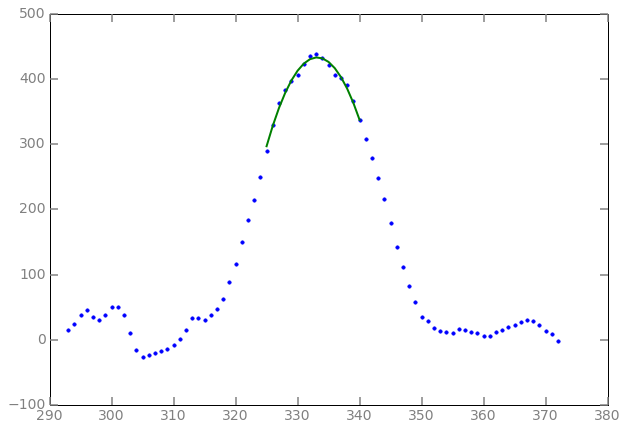

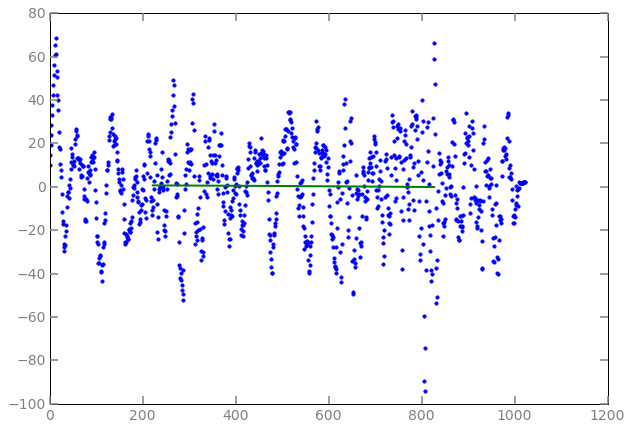

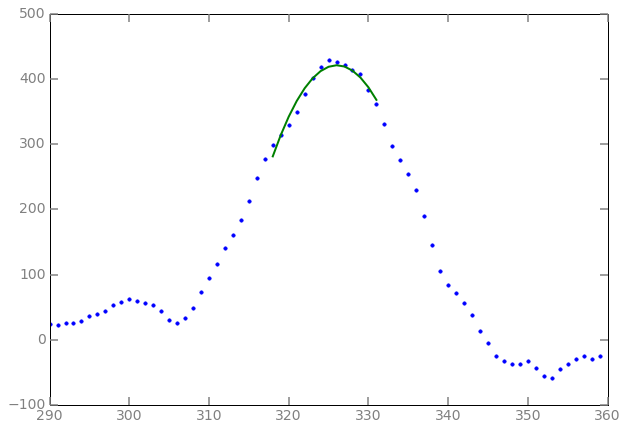

In [9]:
popt = []
perr = [] 

for waveform in ttdiff[12:16]:
    tpo, tpe = ana.fit_peak_parabola_nonlin(waveform, width_ratio=0.7, plot=True)
    popt.append(tpo)
    perr.append(perr)

#### Linear least square

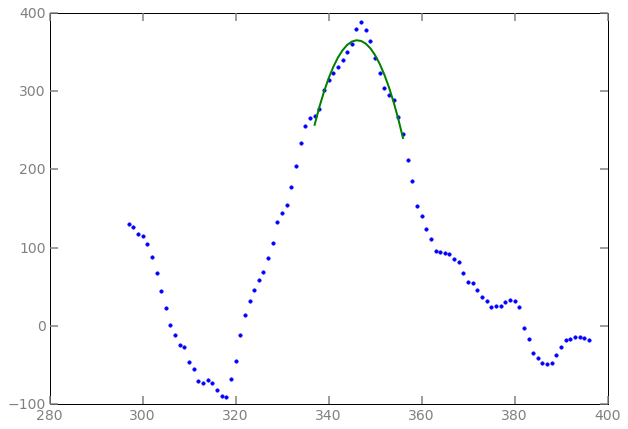

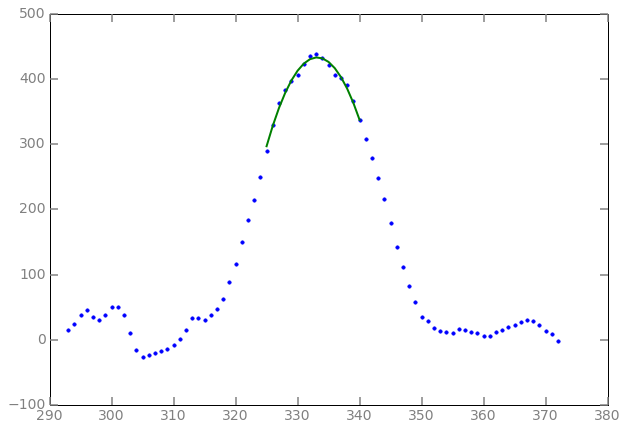

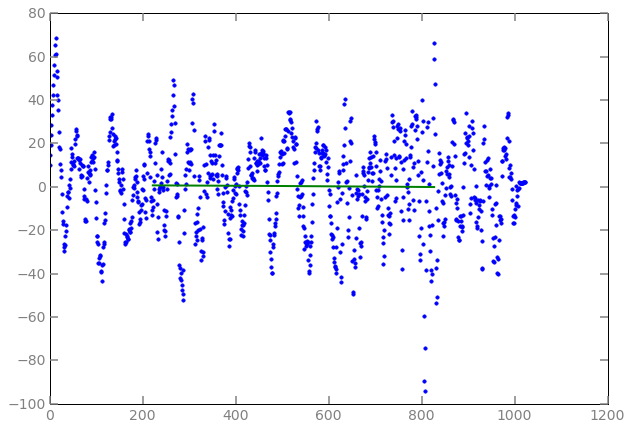

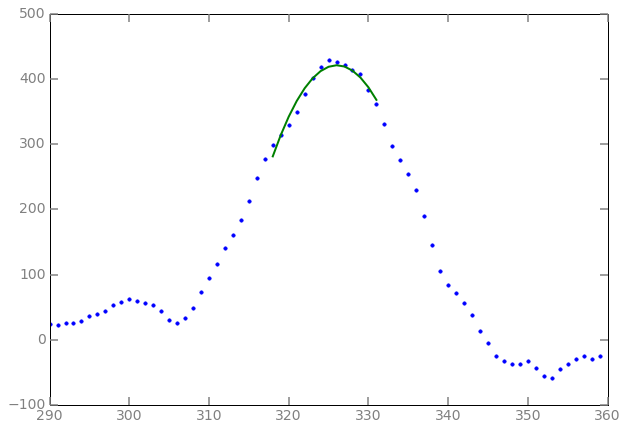

In [ ]:
popt = []

for waveform in ttdiff[12:16]:
    tpo = ana.fit_peak_parabola_lin(waveform, width_ratio=0.7, plot=True)
    popt.append(tpo)

### Find edge: nonlin lsq

In [ ]:
popt = []
perr = [] 

start = time()
for waveform in ttdiff[:]:
    tpo, tpe = ana.fit_peak_parabola_nonlin(waveform, width_ratio=0.7, plot=False)
    popt.append(tpo)
    perr.append(tpe)
end = time()
print("Run time: {0:.0f}s".format(end-start))
    
popt = np.asarray(popt)
edgePos_nlin = popt[:,1]
perr = np.asarray(perr)
errPos_nlin = perr[:,1]
plt.hist(edgePos_nlin[~np.isnan(edgePos_nlin)], bins=np.arange(0,1200,10))
plt.title('Edge position')
plt.show()

plt.figure()
temp = np.logical_or(np.isnan(errPos_nlin), np.isinf(errPos_nlin))
plt.hist(errPos_nlin[~temp], bins=np.arange(0,1.5,0.02))
plt.title('Edge error')
plt.show()

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


### Find edge: lin lsq

In [ ]:
popt = []

start = time()
for waveform in ttdiff[:]:
    tpo = ana.fit_peak_parabola_lin(waveform, width_ratio=0.7, plot=False)
    popt.append(tpo)
end = time()
print("Run time: {0:.0f}s".format(end-start))

popt = np.asarray(popt)
edgePos_lin = popt[:,1]
plt.hist(edgePos_lin[~np.isnan(edgePos_lin)], bins=np.arange(0,1200,10))
plt.title('Edge position')
plt.show()

### Check for nans and outliers, diagnostic

In [ ]:
for edge in [edgePos_nlin, edgePos_lin]:
    nans = np.sum(np.isnan(edge))
    print("nans: {0:d}".format(nans))
    outliers = np.sum( np.logical_or((edge<200),(edge>500)) )
    print("outliers: {0:d}".format(outliers))
    print("total: {0:d}\n".format(outliers+nans))

In [ ]:
testWF = ana.find_nearest(edgePos_nlin[~np.isnan(edgePos_nlin)], 801)
waveform = (ttdiff[~np.isnan(edgePos_nlin)])[testWF]
tpo, tpe = ana.fit_peak_parabola_nonlin(waveform, width_ratio=0.7, plot=True)
tpo

In [ ]:
testWF = ana.find_nearest(edgePos_lin[~np.isnan(edgePos_lin)], 801)
waveform = (ttdiff[~np.isnan(edgePos_lin)])[testWF]
tpo = ana.fit_peak_parabola_lin(waveform, width_ratio=0.7, plot=True)
tpo